***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [200]:
from scipy import stats
from scipy.optimize import minimize, newton

import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# valor da semente padrão
SEED = 42

**Montando o dataset da lista.**

In [3]:
# carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados_completos = climbing_statistics.merge(rainier_weather, left_on="Date", right_on="Date", how="left")
dados_completos = dados_completos.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados_completos = dados_completos.query("Attempted >= Succeeded")
dados_completos = dados_completos.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# aplica as transformações nos dados
dados_completos.Temperatura = (dados_completos.Temperatura - 32) * 5 / 9
dados_completos["Cleaver"] = dados_completos.Route == "Disappointment Cleaver"
dados_completos.Data = pd.to_datetime(dados_completos.Data)

# reordena as colunas de acordo com o layout definido para a lista
dados_completos = dados_completos.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [4]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              4067 non-null   datetime64[ns]
 1   Sucessos          4067 non-null   int64         
 2   Route             4067 non-null   object        
 3   Tentativas        4067 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           4067 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 321.7+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [5]:
dados = dados_completos.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


In [6]:
dados.groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  2.082748  1281
True        8246  3.031618  2720

In [7]:
dados.query("Sucessos > 0").groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  4.214850   633
True        8246  5.093267  1619

In [8]:
diferenca_real = abs(4.214850 - 5.093267)
diferenca_real

0.8784169999999998

In [9]:
lista = dados.query("Sucessos > 0").Sucessos.tolist()
diferencas = []

for i in range(1001):
    lista_sorteada = np.random.choice(lista, size=1619 + 633, replace=False)
    media_true = np.mean(lista_sorteada[:1619])
    media_false = np.mean(lista_sorteada[1620:])
    diferencas.append(abs(media_true - media_false))

<AxesSubplot:ylabel='Density'>

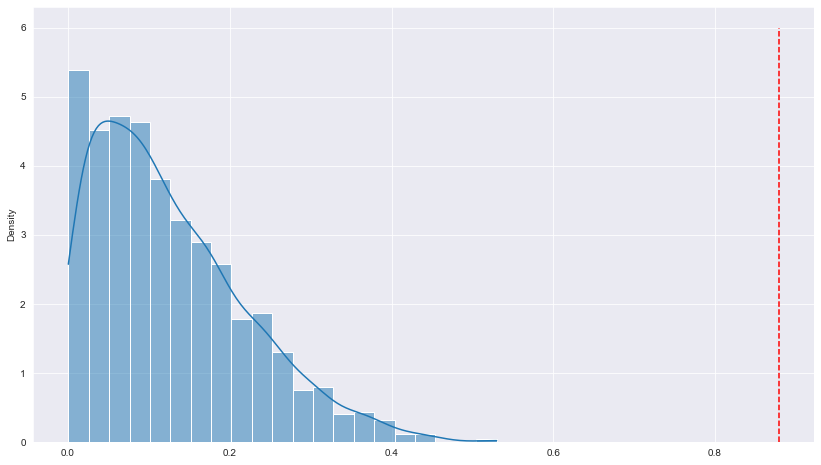

In [10]:
ax = sns.histplot(diferencas, kde=True, stat="density")
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_real, ymin=0, ymax=6, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

In [170]:
dados_poisson = dados.query("not Temperatura.isnull() and Sucessos > 0").groupby(["Data", "Temperatura"]).Sucessos.sum()
dados_poisson = pd.DataFrame(dados_poisson)
dados_poisson.reset_index(inplace=True)

dados_poisson

,Data,Temperatura,Sucessos
0,2014-09-25,-2.875694,8
1,2014-09-26,-2.089815,19
2,2014-09-27,0.732639,25
3,2014-09-28,6.129398,6
4,2014-10-04,6.110417,1
...,...,...,...
127,2015-09-24,2.277546,1
128,2015-09-25,0.216898,15
129,2015-09-26,-2.598843,3
130,2015-09-27,1.725000,6


In [194]:
# Adiciona uma coluna de números 1 junto à variável independente para criar a entrada X
X = sm.add_constant(dados_poisson.Temperatura)

# Renomeia a variável dependente como y (notação padrão)
y = dados_poisson.Sucessos

# Ajusta modelo GLM no statsmodels usando a função de ligação de Poisson
modelo_poisson = sm.GLM(y, X, family=sm.families.Poisson())
resultados_poisson = modelo_poisson.fit()

print(resultados_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Sucessos   No. Observations:                  132
Model:                            GLM   Df Residuals:                      130
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1542.9
Date:                Tue, 06 Dec 2022   Deviance:                       2418.0
Time:                        15:08:27   Pearson chi2:                 2.46e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8830
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.3578      0.022    153.772      

In [197]:
# dados_poisson_temp = dados_poisson.copy()
# dados_poisson_temp["Sucessos_pred"] = resultados_poisson.predict()
# dados_poisson_temp.sort_values("Temperatura")

resultados_poisson.predict([1, 15])[0]

61.31207756094138

In [201]:
# # MLE
# def MLE_Norm(parameters):
#     const, beta, std_dev = parameters
#     pred = const + beta*x
#
#     LL = np.sum(stats.norm.logpdf(y, pred, std_dev))
#     neg_LL = -1*LL
#     return neg_LL

def emv_poisson(parametros):
    alfa, beta = parametros

    LL = np.sum(lm(log(World) ~ days, last_14))
    neg_LL = -1 * LL

    return neg_LL

In [208]:
modelo_emv = minimize(emv_poisson, np.array([3., 3., 3.]), method='L-BFGS-B')
# modelo_emv = minimize(emv_poisson, np.array([3., 3., 3.]), method='BFGS')
# modelo_emv = newton(emv_poisson, np.array([2, 2, 2]))
modelo_emv

C:\Users\pauloceliojr\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: inf
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 4
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([3., 3., 3.])

In [21]:
previsto = stats.poisson.pmf(np.exp(2 + 2 * X.Temperatura), 2)
previsto

X.Temperatura

resultado = np.exp(1 + 1 * -3)
resultado
# stats.poisson.pmf(k=resultado, mu=round(X.Temperatura.mean()))
# np.sum(stats.poisson.logpmf(y, previsto))

0.1353352832366127

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que atemperatura seja de 15 graus.

In [160]:
modelo_poisson.predict([1, 0, 15])[0]

5.021356419134427e-19

### d)

___

Construa um intervalo de confiança de 95% para $exp(\beta)$ a partir do método de bootstrap paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em 1 grau Celsius.

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro quadrático médio(MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtidoem $\textsf{b)}$. Comente os resultados.

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$